## script to load dataset for the first mouse without daily paired spontaneous imaging sessions

In [1]:
# script to convert the uploaded dataset into request format for training

In [2]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import copy
import random

In [3]:


LoadDatafile = "/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData.npz"

with np.load(LoadDatafile,allow_pickle=True) as data:
    AllSerialdffData = data['AlltaskdffSerial'][()]
    AllVRonPeriodData = data['VRonPeriodData'][()]
    AllContextWiseBehav = data['AllContextWiseBehav'][()]
    AllPairTVDatas = data['AllPairTVDatas'][()]
    PairedSessDays = data['PairedSessDays'][()]
    AllpairIsPC = data['PairedIndsIsPC'][()]
    UsedDayStr = data['PairedSessDays'][()]
    SponLastSess_serialDff = data['SponSessDffTrace'][()]
    SponBehavSerials = data['SponBehavSerial'][()]
    
#############
# Including the spatial lcoation datas in the dataset
LoadDatafile2 = "/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData_ROIloc.npz"
# np.savez(Savefile2,AllSessROIcents = AllPairROIcents,AllSessROIPixels=AllPairROIpixels,
#          UsedPairIndex=UsedSess_indexPair,AllpairFOVims = AllPairSessImage)
with np.load(LoadDatafile2,allow_pickle=True) as data2:
    AllPairROIcenter = data2['AllSessROIcents'][()] # this contains the center loc for all ROIs, each 
    AllPairROIpixels = data2['AllSessROIPixels'][()]
    

In [4]:
# AllVRonPeriodData 
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])


In [5]:
# AllPairTVDatas.shape
# for example, if you want the upper half of ROIs in session 1, you can simply use
UsedROIInds = AllPairROIcenter[0][:,0] <= 256 # because the frame size is 512

# # if use all ROIs, another simple way is to
# UsedROIInds = AllPairROIcenter[0][:,0] >= 0

# you can also use random half of the neurons for testing

# reconstruct the whole ROI masks for session 1
Sess1ROIpixels = AllPairROIpixels[0]
RawROImasks = np.zeros((512,512),dtype='float64')
RawROIIndex = np.zeros((512,512),dtype='float64')
MaskColorvalues = np.random.rand(len(Sess1ROIpixels))
for cR in range(len(Sess1ROIpixels)):
    cRpixels = Sess1ROIpixels[cR]
    numofPixels = len(cRpixels['xpix'])
    for cpixel in range(numofPixels):
        RawROImasks[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = MaskColorvalues[cR]
        RawROIIndex[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = cR

     

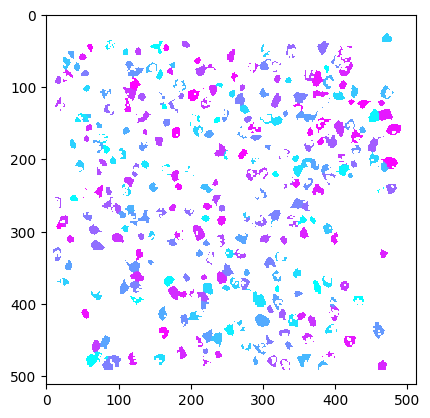

In [6]:
masked_data = np.ma.masked_array(RawROImasks, mask=RawROIIndex==0)
plt.imshow(masked_data,vmin=0,vmax=1,cmap='cool')  

Current session is Day 1


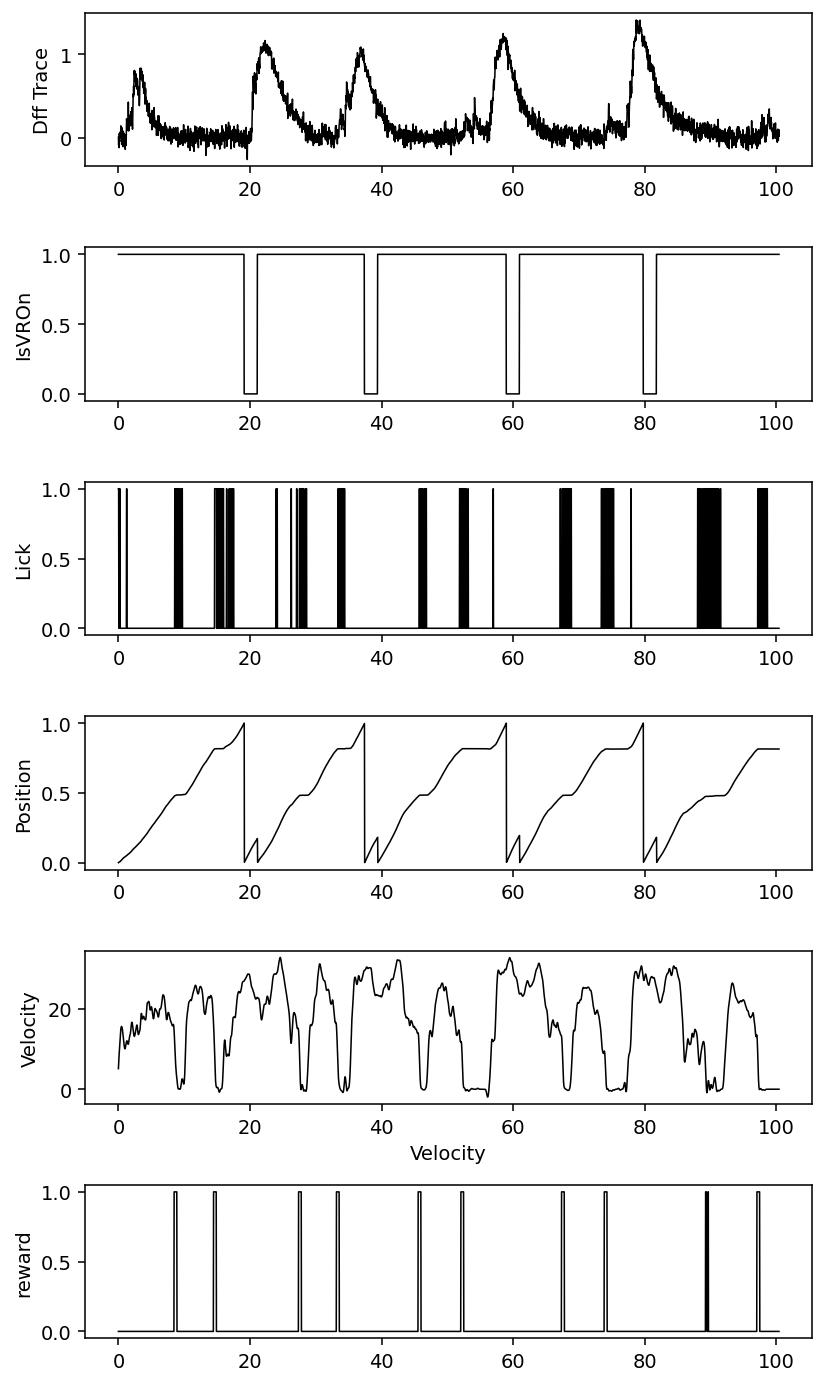

In [7]:
# plot some basic properties of the animal behavior
fr = 29.8739

CheckSessIndex = 0
SessDayStr = PairedSessDays[CheckSessIndex]
print(f"Current session is Day {SessDayStr}")
cSessData = AllSerialdffData[CheckSessIndex]

PlotRange=3000 # only plot the first 3000 frametime events
Frametimes = np.arange(0,PlotRange)/fr
cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"]
fig330, ax030 = plt.subplots(nrows=len(cDataStr), ncols=1, figsize=(6,10),dpi=140)
for cInds in range(6):
    cData = cSessData[cInds]
    if cData.ndim > 1:
        ax030[cInds].plot(Frametimes,cData[0,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
    else:
        ax030[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
    ax030[cInds].set_ylabel(cDataStr[cInds])
    if cInds == 4: # last plot add xlabel
        ax030[cInds].set_xlabel(cDataStr[cInds])

plt.tight_layout()

Current session is Spontaneous recording at Day 10


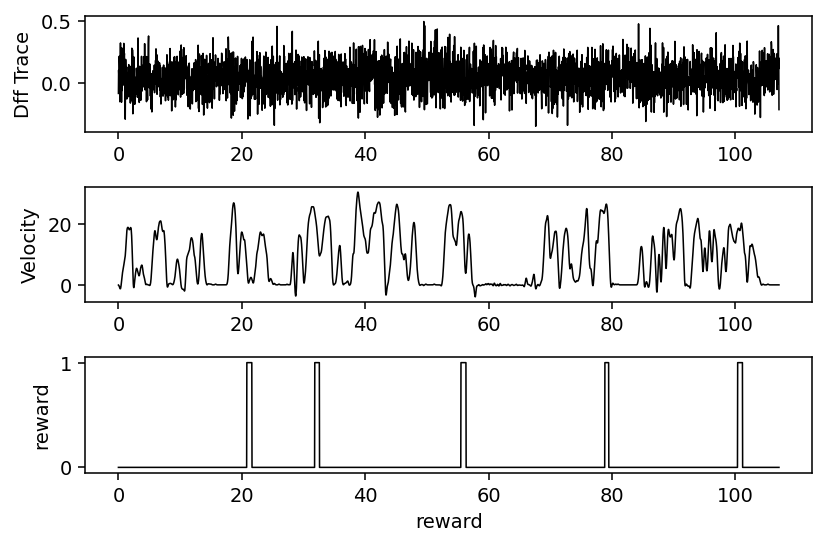

In [8]:
# VR off Sponteneous conditions

fr = 29.8739

print(f"Current session is Spontaneous recording at Day 10")

PlotRange=3200 # only plot the first 3000 frametime events
Frametimes = np.arange(0,PlotRange)/fr
PlotDatas = [SponLastSess_serialDff,SponBehavSerials[0],SponBehavSerials[1]]
cDataStr = ["Dff Trace","Velocity","reward"]
Numofplots = len(PlotDatas)
fig3302, ax0302 = plt.subplots(nrows=Numofplots, ncols=1, figsize=(6,4),dpi=140)
for cInds in range(Numofplots):
    cData = PlotDatas[cInds]
    if cData.ndim > 1:
        ax0302[cInds].plot(Frametimes,cData[2,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
    else:
        ax0302[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
    ax0302[cInds].set_ylabel(cDataStr[cInds])
    if cInds == Numofplots-1: # last plot add xlabel
        ax0302[cInds].set_xlabel(cDataStr[cInds])

plt.tight_layout()

In [9]:
# constructing current dataset into requested format
# T = sessions (days)
# S =  trials per session
# K =  time bins per trial
# N =  neurons (half neurons)
# x: neural activity
#  shape: [T, S, K, N]
# v: animal velocity
#  shape: [T, S, K]
# u: animal position (target)
# shape: [T, S, K]
# W0: initial connectivity
# shape: [N, N] 

## trail equals to lap in all contents ##

# AllPairedSerialData.append([SerialdffTrace,cTaskVROnFrames,cSessTaskparas['licking'],
#                                cSessTaskparas['treadmillPosition'],cSessTaskparas['velocity'],cSessTaskparas['reward'],
#                                 cTask_lapseclist,cSessTaskparas['lap_bin']])
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])

MaxlapIndex = 15 # used to define what are the laps (trials) will be used. If you want to use all laps, just set it to a high number (e.g. 200)
NumSessions = len(AllSerialdffData)
print(f"Current session have {NumSessions} sessions.")

# each trial will have different length of time bin, you can use this to append the time bin dimension to max
TrialTimeBinLen = []

x = []
v = []
u = []

for cSess in range(NumSessions):
    # cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"] # Serial data contents
    cSessSerialData = AllSerialdffData[cSess]
    cSessTaskPerf = AllVRonPeriodData[cSess]
    VROnFrames = cSessSerialData[1] # VR on frames indices
    # including VR-on frames only
    cSessdffTrace = cSessSerialData[0][UsedROIInds,:][:,VROnFrames] # Only includes used ROIs and VRon frames
    cSesspos = cSessSerialData[3][VROnFrames]
    cSessVelocity = cSessSerialData[4][VROnFrames]
    
    cSesslapIndex = cSessTaskPerf[4]
    usedlapInds = cSesslapIndex < MaxlapIndex
    cusedlapIndex = cSesslapIndex[usedlapInds]
    
    S = np.max(cSesslapIndex[usedlapInds])
    cSesstrbinlen = []
    cSess_dffTrace = []
    cSess_Velocity = []
    cSess_position = []
    for ctrial in range(S+1):
        ctrial_inds = cusedlapIndex == ctrial
        cTrial_dffTrace = cSessdffTrace[:,usedlapInds][:,ctrial_inds] # current trial data, in a shape of N by K
        cTrial_Velocity = cSessVelocity[usedlapInds][ctrial_inds]
        cTrial_position = cSesspos[usedlapInds][ctrial_inds]
        
        cSesstrbinlen.append(len(cTrial_Velocity))
        cSess_dffTrace.append(cTrial_dffTrace.T) # convert into a shape of K by N
        cSess_Velocity.append(cTrial_Velocity)
        cSess_position.append(cTrial_position)
        
    TrialTimeBinLen.append(cSesstrbinlen) # used to append the trial time bin to maximum len
    x.append(cSess_dffTrace)
    v.append(cSess_Velocity)
    u.append(cSess_position)
    

Current session have 8 sessions.


In [10]:
# padding the trial time bins into maximum dimension ?


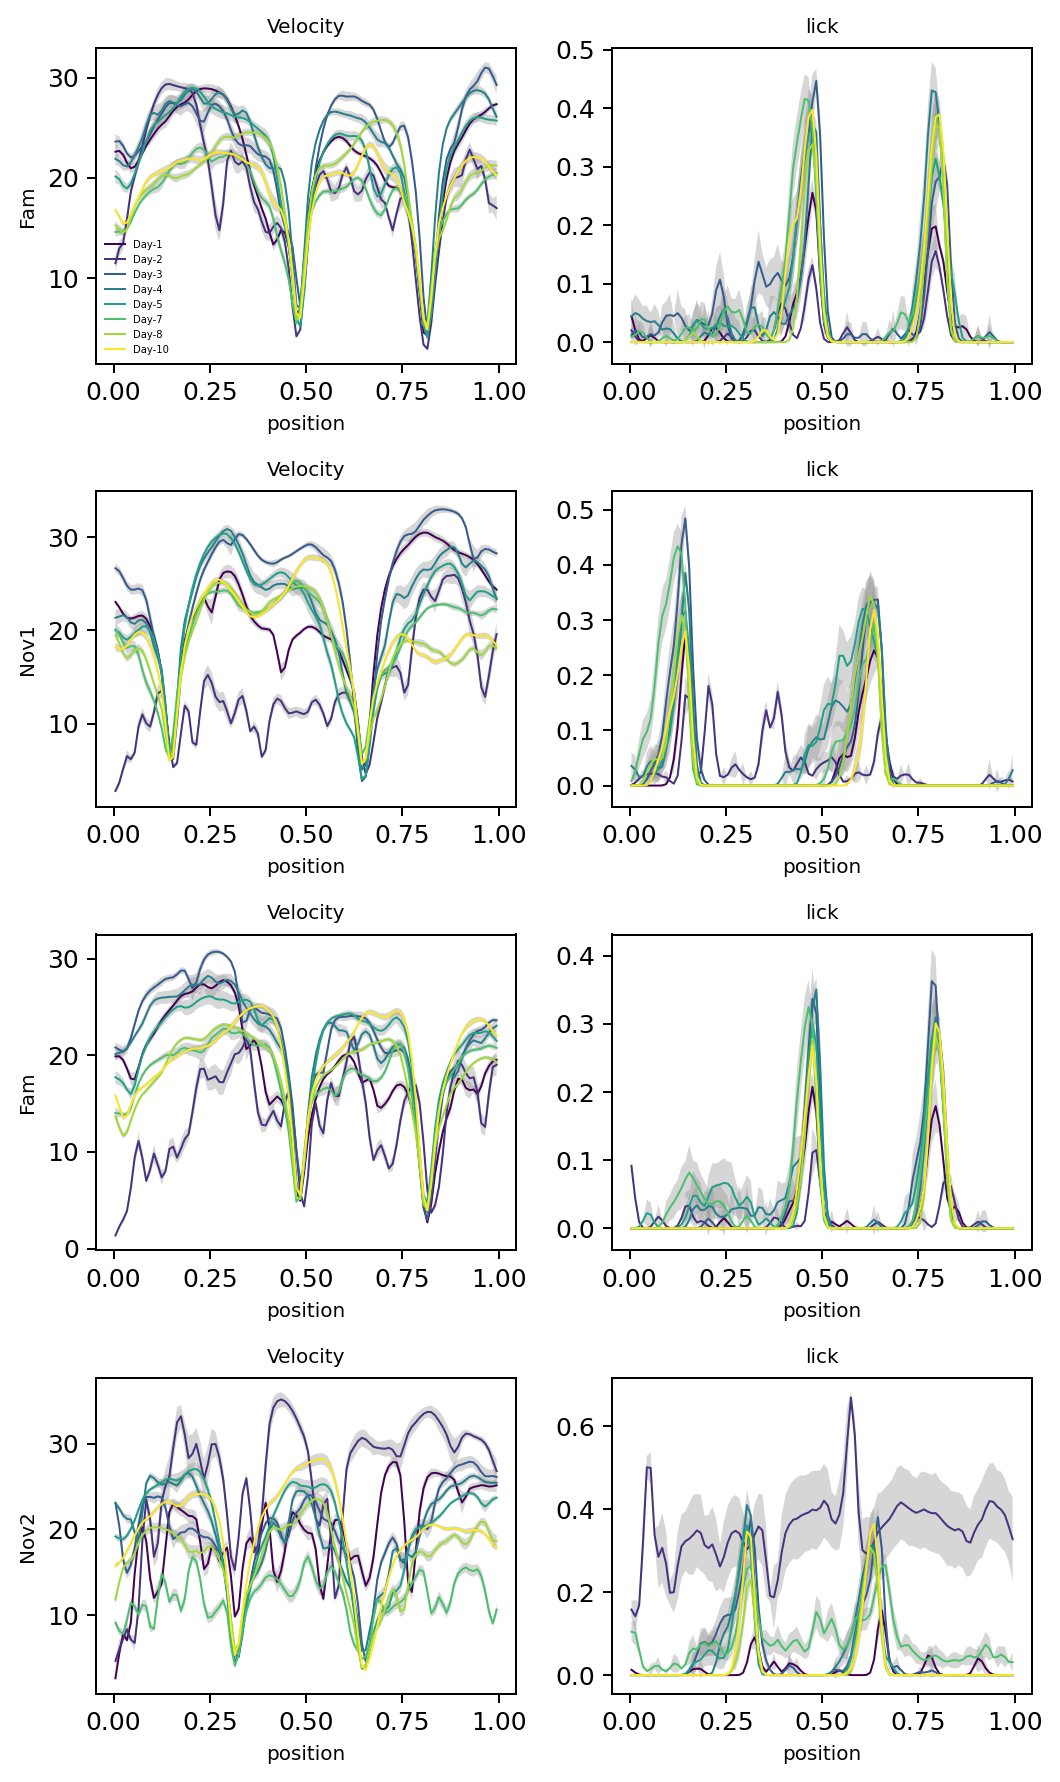

In [11]:
# plt.plot(cTaskFramePos,cTaskFrameLicks,'ko',ms=1)
fig32, ax02 = plt.subplots(nrows=4, ncols=2, figsize=(6,10),dpi=180)
nBins = 100
LocBins = np.linspace(0.0,1.0,nBins+1)

cmap = plt.get_cmap('viridis')
laplineColors = cmap(np.linspace(0,1,len(PairedSessDays)))
spbincents = (LocBins[:-1]+LocBins[1:])/2

PlotData = 0 # 0 indicates Velocity, 1 indicates licks, 2 indicates reward
PlotDataStr = ['Velocity','lick']
cContext = 0
ContextStrs = ['Fam','Nov1','Fam','Nov2']
UsedInds = np.arange(0,len(PairedSessDays)).astype('int')

k = 0
for cData in range(2):
    for cContext in range(4):
        cax = ax02[cContext,cData]
        for Inds,Days in enumerate(UsedInds):
            cSessData = AllContextWiseBehav[Inds][cContext][cData]
            SmoothedTrace = gaussian_filter1d(cSessData[0],1)
            cax.fill_between(spbincents,SmoothedTrace-cSessData[1],SmoothedTrace+cSessData[1],
                        alpha=0.4,ec='none',fc=[0.6,0.6,0.6])
            cax.plot(spbincents,SmoothedTrace,lw=0.8,color=laplineColors[Inds],label=f"Day-{PairedSessDays[Inds]}")
        if cData%2 == 0:
            cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
            cax.set_ylabel(f"{ContextStrs[cContext]}",fontsize=8)
            cax.set_xlabel("position",fontsize=8)
        else:
            cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
            cax.set_xlabel("position",fontsize=8)
        k += 1
ax02[0,0].legend(fontsize=4,loc='best',shadow=None,frameon=False)
plt.tight_layout()

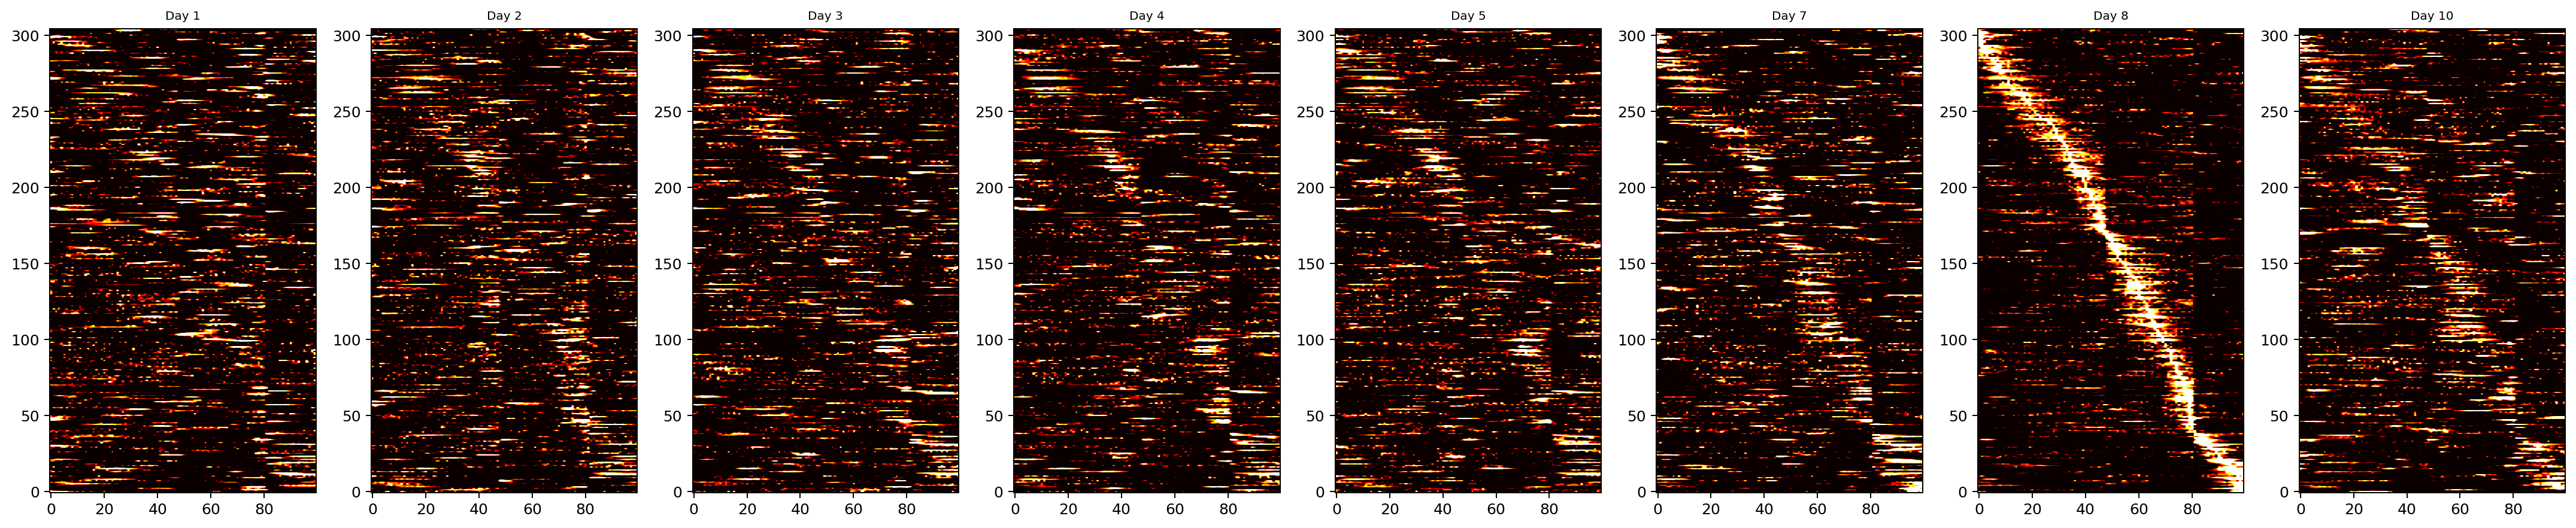

In [12]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[:,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[:,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=2,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {PairedSessDays[cSess]}",fontsize=8)
plt.tight_layout()

# the behavior performance changes during imaging

# pick out the stable cells, fraction of it
# detection of place field, stability of PF criteria

# activity during ITI
# raw time serial data and labeled ITI data




In [13]:
RefSess=0
UsedContext = 0
AllCorr2Ref = []
AllShufCorrs = []

for UsedSess in range(NumberofColumns-1):
    A = AllPairTVDatas[:,UsedContext,:,RefSess]
    B = AllPairTVDatas[:,UsedContext,:,UsedSess+1]
    diag_pear_coef = np.array([stats.pearsonr(A[i, :], B[i, :])[0] for i in range(A.shape[0])])
    if len(AllCorr2Ref) == 0:
        AllCorr2Ref = diag_pear_coef[:,np.newaxis]
    else:
        AllCorr2Ref = np.concatenate((AllCorr2Ref,diag_pear_coef[:,np.newaxis]),axis=1)
    
    A_shuf = copy.copy(A)
    random.shuffle(A_shuf)
    # random_samples2 = random.choice(B.shape[0], size=1000)
    B_shuf = copy.copy(B)
    random.shuffle(B_shuf)

    for c in range(5):
        ShufNullCorrs = [stats.pearsonr(A_shuf[i, :], B_shuf[i, :])[0] for i in range(A_shuf.shape[0])]
        AllShufCorrs.extend(ShufNullCorrs)
    
# ShufNullCorrs = 

In [14]:
shufCorrthreshold = np.percentile(AllShufCorrs,[95,99])
Mtx = AllCorr2Ref>shufCorrthreshold[0]
SigROIs = np.argwhere(np.sum(Mtx,axis=1)>=3)[:,0]
SigROIs
# plt.imshow(AllCorr2Ref>shufCorrthreshold[0],aspect='auto',vmin=0,vmax=1)

array([  0,   4,   8,   9,  10,  12,  13,  25,  27,  29,  30,  33,  38,
        44,  45,  47,  48,  53,  63,  74,  88,  91,  98,  99, 100, 105,
       106, 110, 129, 167, 176, 185, 186, 188, 237, 297, 302])

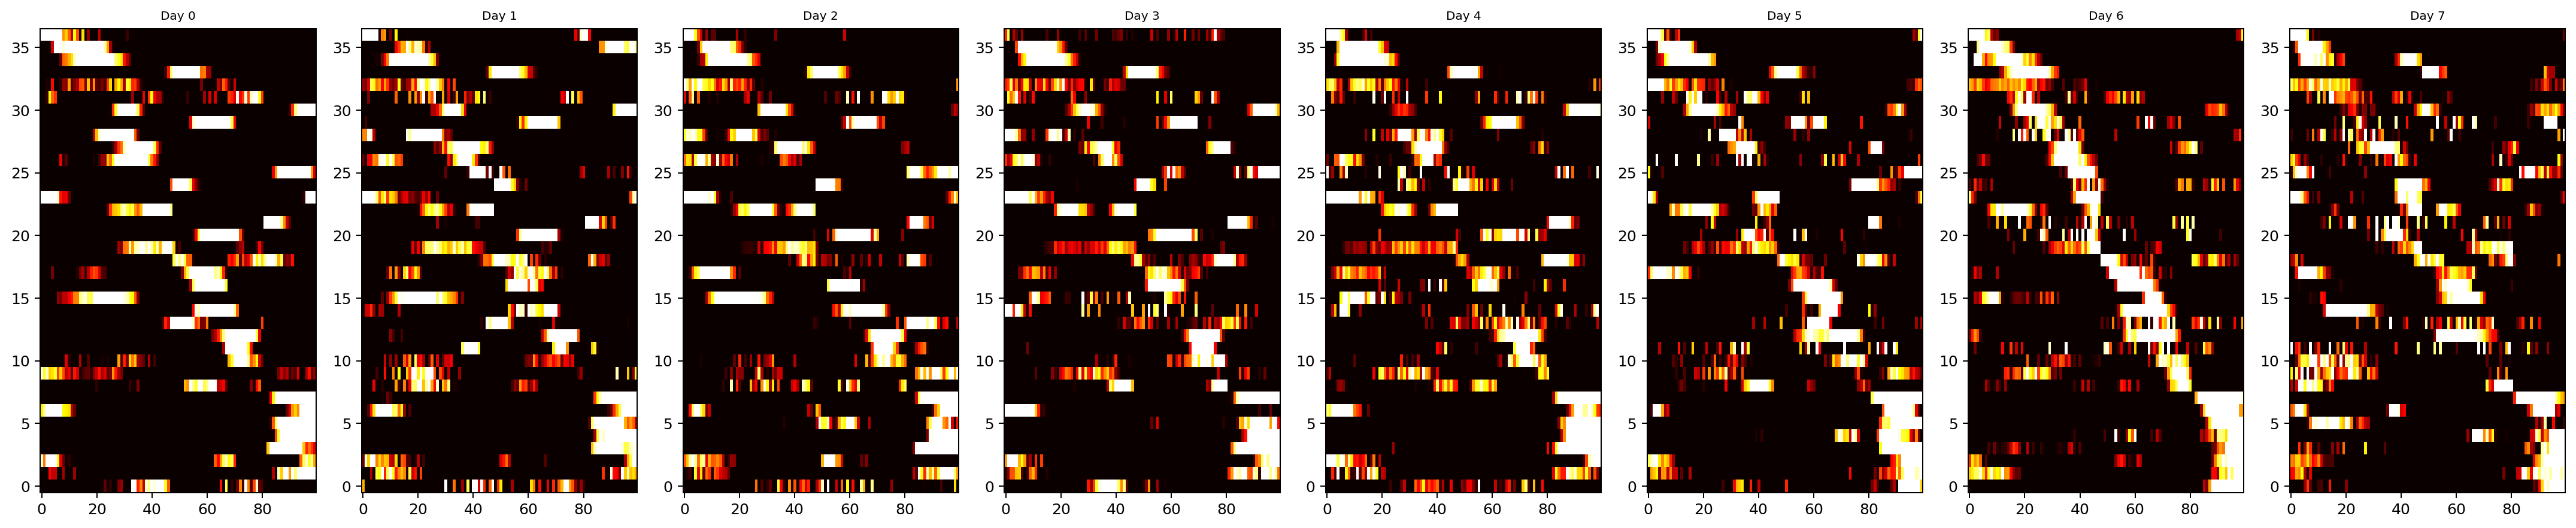

In [15]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[SigROIs,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[SigROIs,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=1.6,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {UsedInds[cSess]}",fontsize=8)
plt.tight_layout()

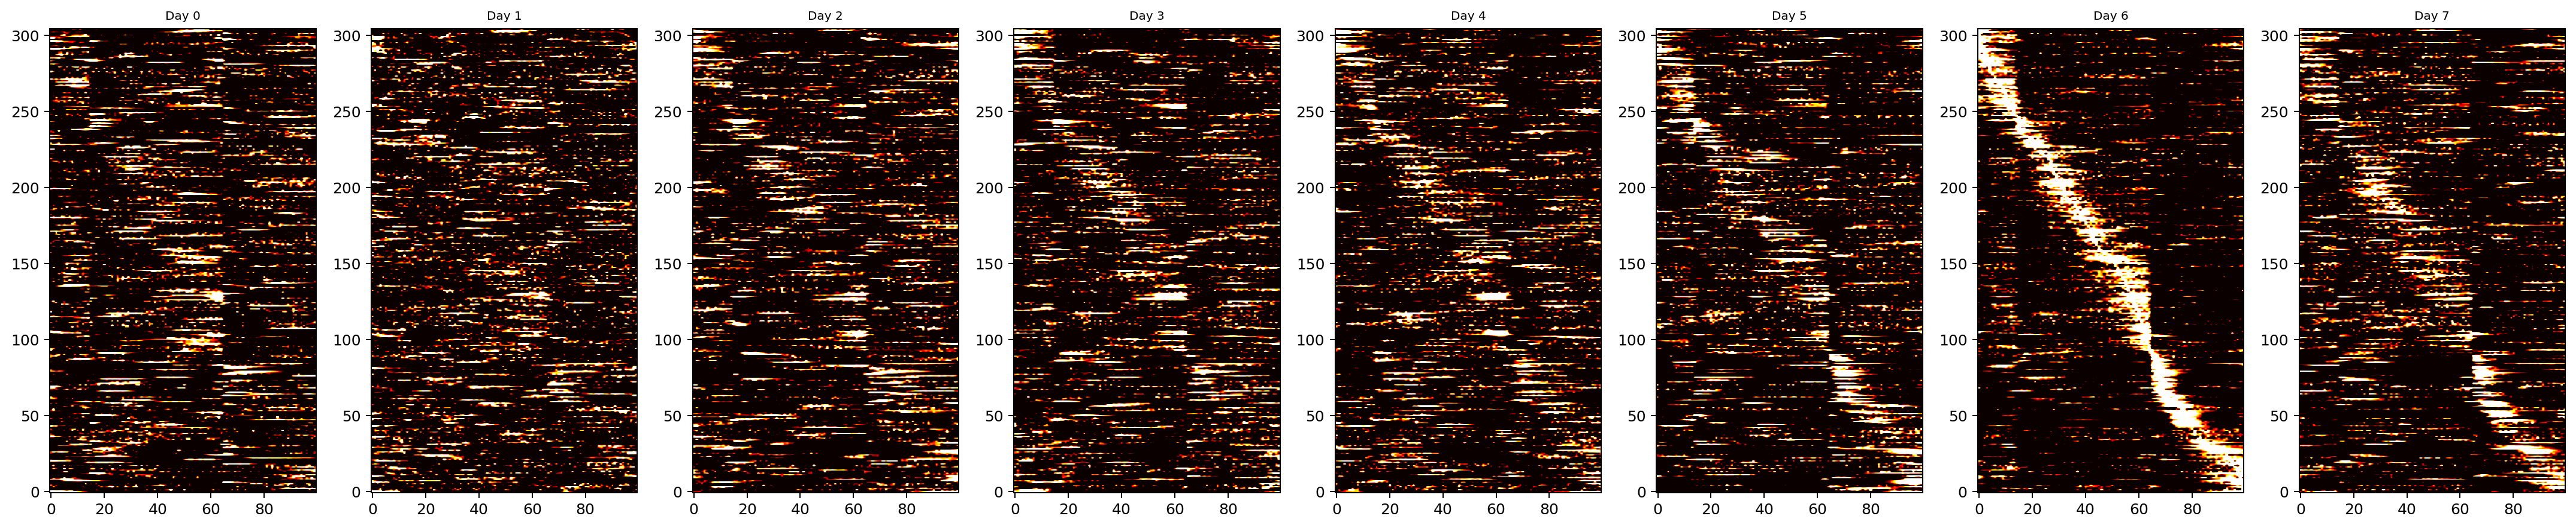

In [16]:
UsedContext = 1
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[:,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[:,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=1.6,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {UsedInds[cSess]}",fontsize=8)
plt.tight_layout()

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_traces(DataArr, IsPFcell, ax=None, linewidth=0.8, fill_color='r', Rowseqs=None,
                        fill_alpha=0.6, line_color='k', spacing_factor=1.2,IsSepplot = False):
    """
    Plot stacked traces from a 2D array with area fill for place field cells.
    
    Parameters:
    -----------
    DataArr : numpy.ndarray
        2D array where each row is a trace to be plotted
    IsPFcell : numpy.ndarray
        Boolean array indicating which rows are place field cells (True) to be filled
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure and axes will be created
    linewidth : float, optional
        Width of the trace lines
    fill_color : str, optional
        Color for filling area under place field cell traces
    fill_alpha : float, optional
        Alpha transparency for the fill (0-1)
    line_color : str, optional
        Color for the trace lines
    spacing_factor : float, optional
        Factor to control spacing between traces (higher = more space)
    IsSepplot: bool, optional
        whether seperately plot the PC and non-PC traces
    
    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axes with the plotted traces
    """
    # Check input dimensions
    if DataArr.shape[0] != len(IsPFcell):
        raise ValueError("DataArr and IsPFcell must have the same number of rows")
    if Rowseqs is None: 
        # sort data
        Rowpeaks = np.argmax(DataArr,axis=1)
        Rowseqs = np.argsort(Rowpeaks)
    else:
        # not performing seperate plots even if IsSepplot is True
        IsSepplot = False
        
    SortedDataArr = DataArr[Rowseqs,:]
    SortedIsPC = IsPFcell[Rowseqs]
    
    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 20),dpi=120)
    
    num_traces = DataArr.shape[0]
    x_vals = np.arange(DataArr.shape[1])
    
    # Calculate appropriate y-spacing
    trace_heights = np.array([np.max(DataArr[i]) - np.min(DataArr[i]) for i in range(num_traces)])
    max_height = np.max(trace_heights)
    y_spacing = max_height * spacing_factor
    if IsSepplot:
        Sorted_PCTraces = SortedDataArr[SortedIsPC]
        Sorted_NonPCTraces = SortedDataArr[~SortedIsPC]
        y_offset = 0
        # Plot each trace
        for i in range(Sorted_PCTraces.shape[0]):
            # Calculate y-offset for this trace
            
            # Fill area under curve if it's a place field cell
            # Plot the trace
            ax.plot(x_vals, Sorted_PCTraces[i] - y_offset, color='r', linewidth=linewidth)

            ax.fill_between(x_vals, -y_offset, Sorted_PCTraces[i] - y_offset, 
                           color=fill_color, alpha=fill_alpha)
            y_offset += y_spacing
        
        for ii in range(Sorted_NonPCTraces.shape[0]):
            ax.plot(x_vals, Sorted_NonPCTraces[ii] - y_offset, color=[.7,.7,.7], linewidth=linewidth*0.5)
            y_offset += y_spacing
            
            
    else:
        # Plot each trace
        for i in range(num_traces):
            # Calculate y-offset for this trace
            y_offset = i * y_spacing
            # Fill area under curve if it's a place field cell
            if SortedIsPC[i]:
                # Plot the trace
                ax.plot(x_vals, SortedDataArr[i] - y_offset, color='r', linewidth=linewidth)

                ax.fill_between(x_vals, -y_offset, SortedDataArr[i] - y_offset, 
                               color=fill_color, alpha=fill_alpha)
            else:
                ax.plot(x_vals, SortedDataArr[i] - y_offset, color=[.7,.7,.7], linewidth=linewidth*0.5)
    
    # Set y-ticks at the center of each trace
    # ax.set_yticks(np.arange(num_traces) * y_spacing)
    # ax.set_yticklabels([f'Cell {i+1}' for i in range(num_traces)])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([1,-y_offset-3])
    
    # # Set labels
    # ax.set_xlabel('Position')
    # ax.set_ylabel('Cell ID')
    
    return ax,Rowseqs

In [18]:
AllPairTVDatas.shape
# AllPairTVDatas  AllpairIsPC

(305, 4, 100, 8)

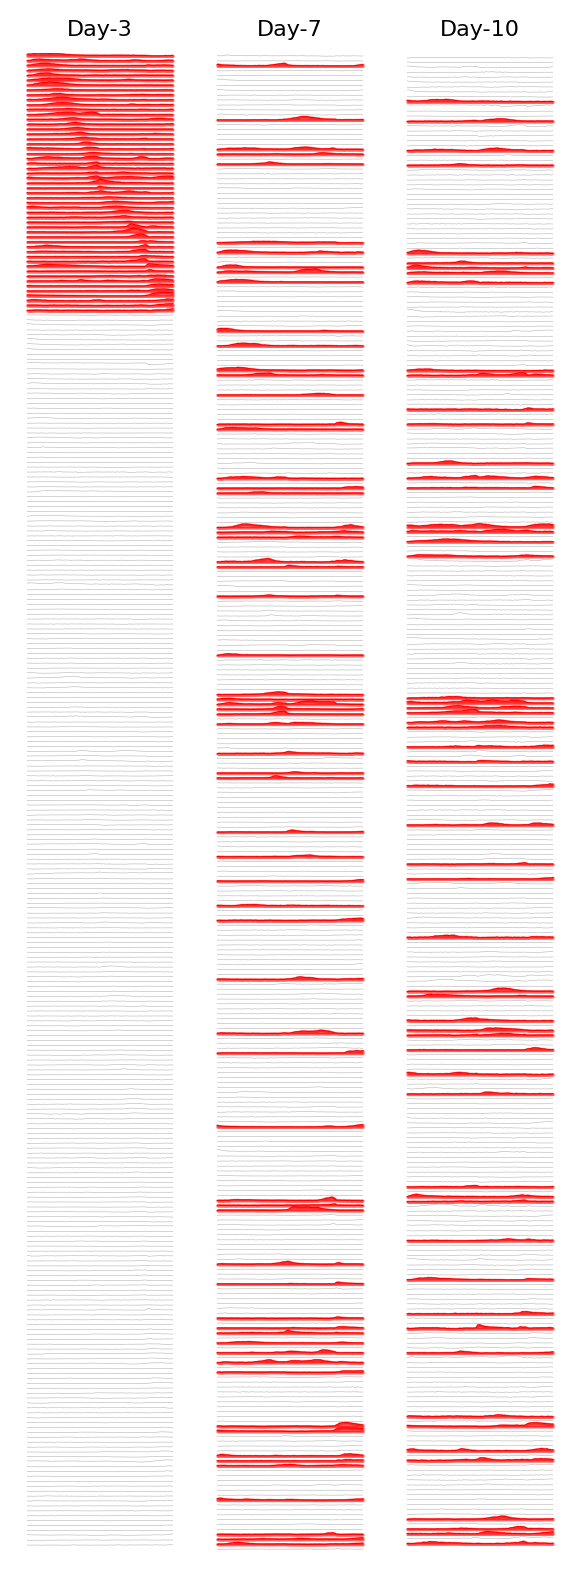

In [24]:
cContext = 0

PlotSess = [2,5,7] #UsedDayStr
PlotDayStr = [UsedDayStr[c] for c in PlotSess]
numofSess = len(PlotSess)
SortSeq = None
fig, axAll = plt.subplots(nrows=1, ncols=numofSess,figsize=(1*numofSess, 8),dpi=200)
for inds,cSess in enumerate(PlotSess):
    ax = axAll[inds]
    ContexturnCurve = AllPairTVDatas[:,cContext,:,cSess]
    ContextRIsPC = AllpairIsPC[cSess][cContext]
    # print(ContexturnCurve.shape)
    # print(ContextRIsPC.shape)
    ax,SortSeq = plot_stacked_traces(ContexturnCurve, ContextRIsPC,ax=ax,Rowseqs=SortSeq,linewidth=0.4,IsSepplot = True)
    
    ax.set_axis_off()
    ax.set_title(f"Day-{PlotDayStr[inds]}",fontsize=8)
    ax.invert_yaxis()

plt.tight_layout()


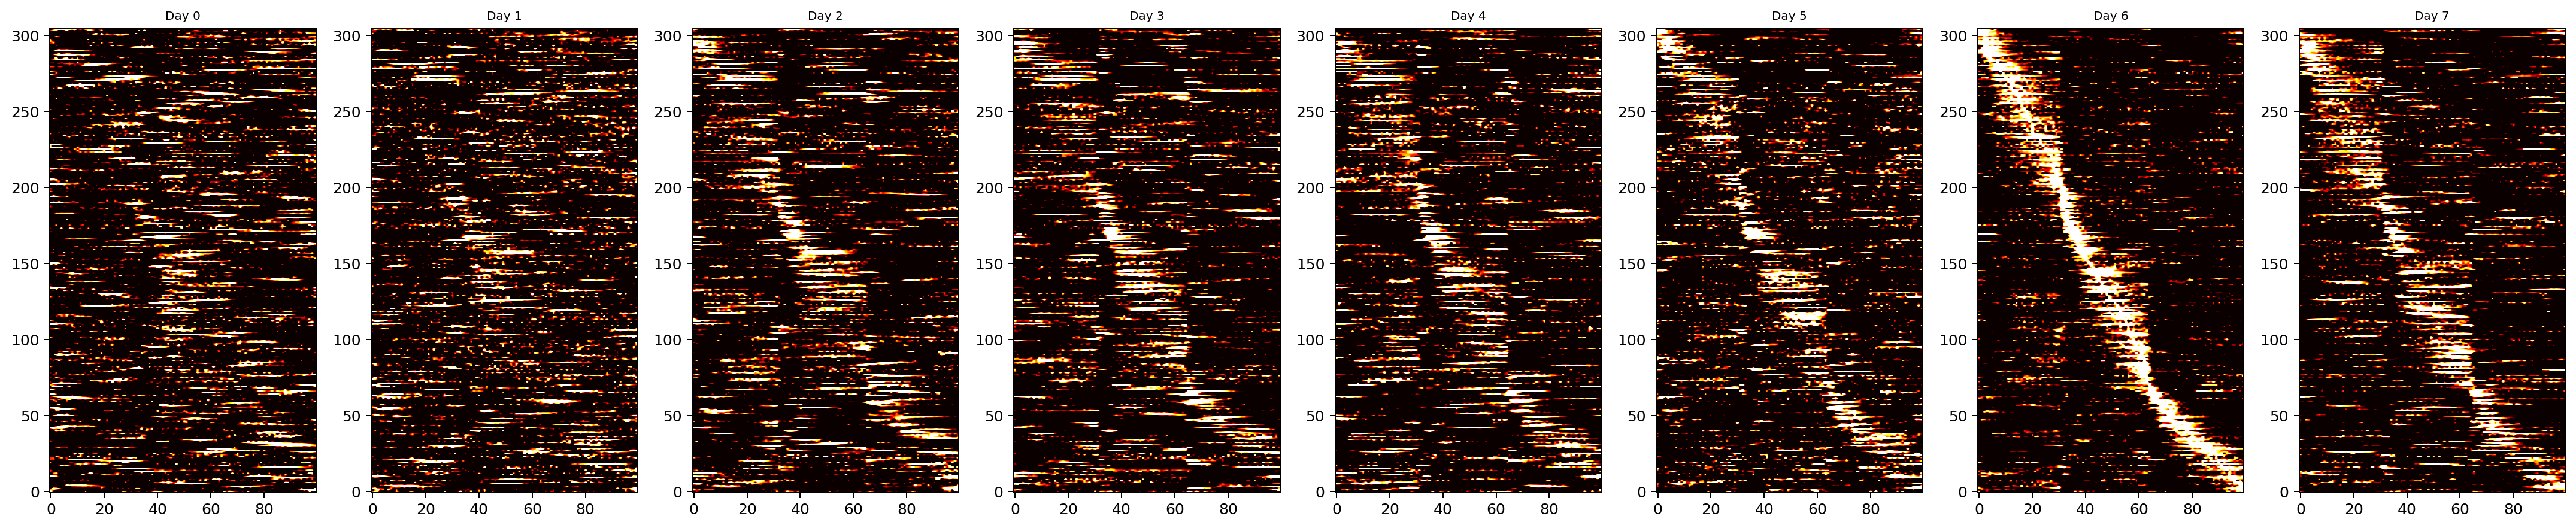

In [20]:
UsedContext = 3
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[:,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[:,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=1.6,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {UsedInds[cSess]}",fontsize=8)
plt.tight_layout()

## Script section for loading another mouse's data, with more spontaneous activity sessions 

In [21]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import copy
import random

In [29]:

PATH_FOLDER = "/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /"
LoadDatafile = os.path.join(PATH_FOLDER,"WeekLearningData_b022a01.npz")

with np.load(LoadDatafile,allow_pickle=True) as data:
    AllSerialdffData = data['AlltaskdffSerial'][()]
    AllVRonPeriodData = data['VRonPeriodData'][()]
    AllContextWiseBehav = data['AllContextWiseBehav'][()]
    AllPairTVDatas = data['AllPairTVDatas'][()]
    PairedSessDays = data['PairedSessDays'][()]
    AllpairIsPC = data['PairedIndsIsPC'][()]
    UsedDayStr = data['PairedSessDays'][()]
    SponBehavANDdffSerials = data['SponBehavANDdffSerial'][()] # paired spontaneous session data corresponded to each VR on task session
    
#############
# Including the spatial lcoation datas in the dataset
LoadDatafile2 = os.path.join(PATH_FOLDER,"WeekLearningData_ROIloc_b022a01.npz")
# np.savez(Savefile2,AllSessROIcents = AllPairROIcents,AllSessROIPixels=AllPairROIpixels,
#          UsedPairIndex=UsedSess_indexPair,AllpairFOVims = AllPairSessImage)
with np.load(LoadDatafile2,allow_pickle=True) as data2:
    AllPairROIcenter = data2['AllSessROIcents'][()] # this contains the center loc for all ROIs, each 
    AllPairROIpixels = data2['AllSessROIPixels'][()]

print(f"Loaded data from session days:\n {UsedDayStr}")    

Loaded data from session days:
 ['4' '5' '6' '7']


In [ ]:
# AllVRonPeriodData 
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])


In [ ]:
# AllPairTVDatas.shape
# for example, if you want the upper half of ROIs in session 1, you can simply use
UsedROIInds = AllPairROIcenter[0][:,0] <= 256 # because the frame size is 512

# # if use all ROIs, another simple way is to
# UsedROIInds = AllPairROIcenter[0][:,0] >= 0

# you can also use random half of the neurons for testing

# reconstruct the whole ROI masks for session 1
Sess1ROIpixels = AllPairROIpixels[0]
RawROImasks = np.zeros((512,512),dtype='float64')
RawROIIndex = np.zeros((512,512),dtype='float64')
MaskColorvalues = np.random.rand(len(Sess1ROIpixels))
for cR in range(len(Sess1ROIpixels)):
    cRpixels = Sess1ROIpixels[cR]
    numofPixels = len(cRpixels['xpix'])
    for cpixel in range(numofPixels):
        RawROImasks[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = MaskColorvalues[cR]
        RawROIIndex[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = cR

     

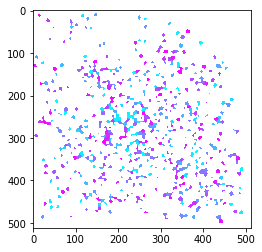

In [ ]:
masked_data = np.ma.masked_array(RawROImasks, mask=RawROIIndex==0)
plt.imshow(masked_data,vmin=0,vmax=1,cmap='cool')  

Current session is Day 4


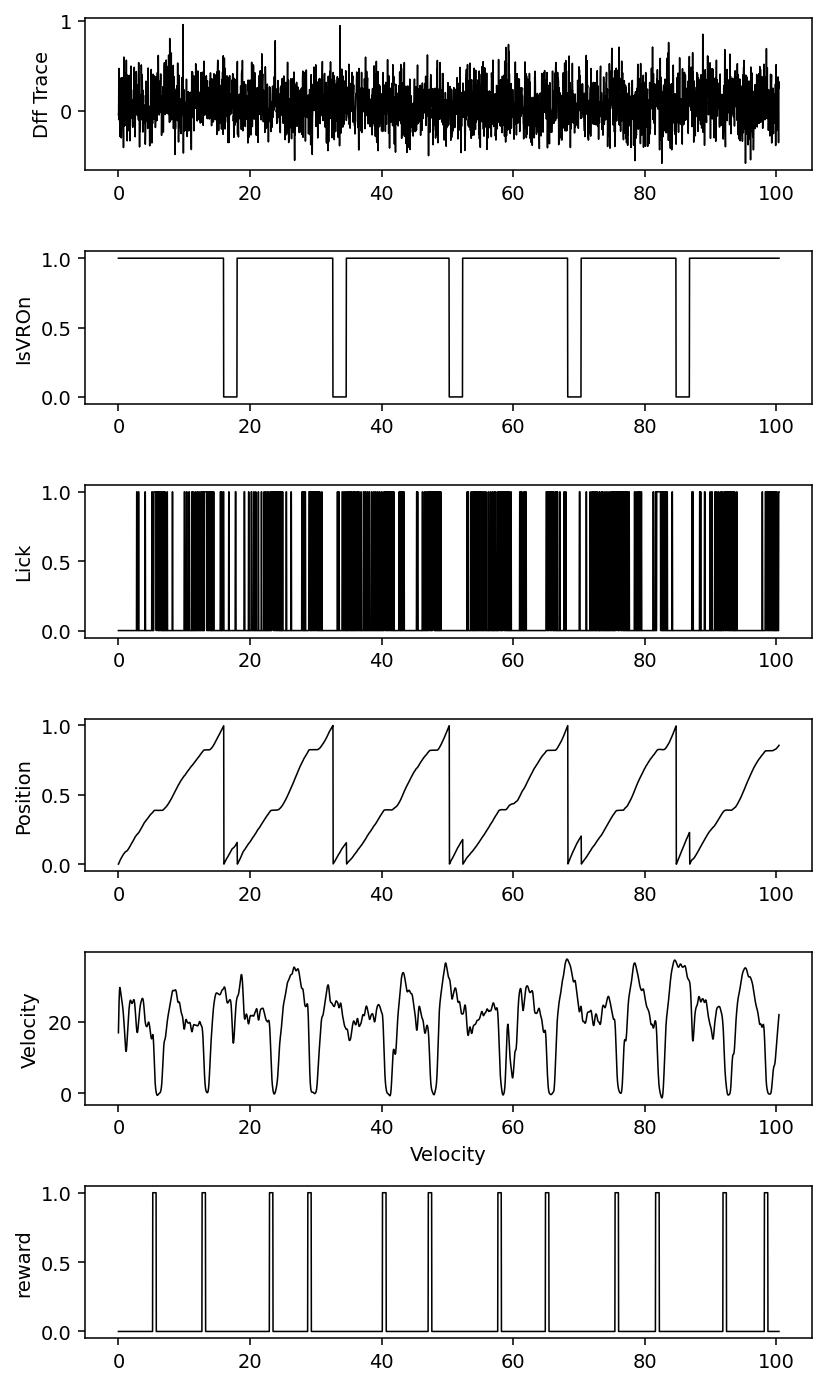

In [ ]:
# plot some basic properties of the animal behavior
fr = 29.8739

CheckSessIndex = 0
SessDayStr = PairedSessDays[CheckSessIndex]
print(f"Current session is Day {SessDayStr}")
cSessData = AllSerialdffData[CheckSessIndex]

PlotRange=3000 # only plot the first 3000 frametime events
Frametimes = np.arange(0,PlotRange)/fr
cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"]
fig330, ax030 = plt.subplots(nrows=len(cDataStr), ncols=1, figsize=(6,10),dpi=140)
for cInds in range(6):
    cData = cSessData[cInds]
    if cData.ndim > 1:
        ax030[cInds].plot(Frametimes,cData[0,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
    else:
        ax030[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
    ax030[cInds].set_ylabel(cDataStr[cInds])
    if cInds == 4: # last plot add xlabel
        ax030[cInds].set_xlabel(cDataStr[cInds])

plt.tight_layout()

Current spontaneous session is paired with VR session Day 4


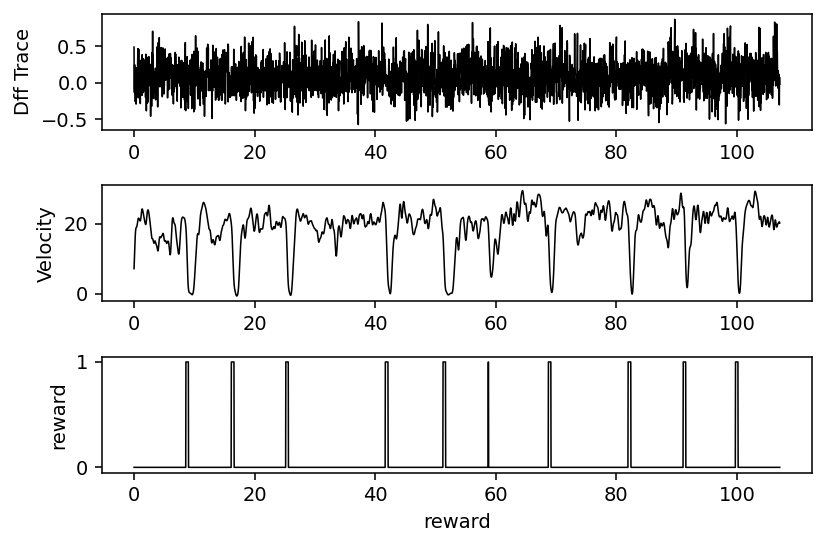

In [ ]:
# VR off Sponteneous conditions

fr = 29.8739

print(f"Current spontaneous session is paired with VR session Day {SessDayStr}")
# CheckSessIndex
if len(SponBehavANDdffSerials[CheckSessIndex]) == 0:
    print("Paired spontaneous session doesnt exists.")
else:
    PlotRange=3200 # only plot the first 3000 frametime events
    Frametimes = np.arange(0,PlotRange)/fr
    
    PlotDatas = [SponBehavANDdffSerials[CheckSessIndex][1],SponBehavANDdffSerials[CheckSessIndex][0]['velocity'],
                 SponBehavANDdffSerials[CheckSessIndex][0]['reward']] # FormatBehaveEvs_spon['velocity'],FormatBehaveEvs_spon['reward']
    cDataStr = ["Dff Trace","Velocity","reward"]
    Numofplots = len(PlotDatas)
    fig3302, ax0302 = plt.subplots(nrows=Numofplots, ncols=1, figsize=(6,4),dpi=140)
    for cInds in range(Numofplots):
        cData = PlotDatas[cInds]
        if cData.ndim > 1:
            ax0302[cInds].plot(Frametimes,cData[2,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
        else:
            ax0302[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
        ax0302[cInds].set_ylabel(cDataStr[cInds])
        if cInds == Numofplots-1: # last plot add xlabel
            ax0302[cInds].set_xlabel(cDataStr[cInds])

    plt.tight_layout()

In [ ]:
# if you want to use any spontaneous session to construct the connection matrix, you can get the data via:
UsedSess = 0
if len(SponBehavANDdffSerials[UsedSess]) == 0:
    # means current session do not have (or bad focus) paired spntaneous session recording
    print("Spon data not exists")
else:
    SponROI_dfftrace = SponBehavANDdffSerials[CheckSessIndex][1]
    SponROI_velocitySerial = SponBehavANDdffSerials[CheckSessIndex][0]['velocity']
    SponROI_rewardSerial = SponBehavANDdffSerials[CheckSessIndex][0]['reward']
    
    # position value do not make sense here, so just ignore it
    # let me know if any other info is needed to calculate the connection matrix


In [ ]:
# constructing current dataset into requested format
# T = sessions (days)
# S =  trials per session
# K =  time bins per trial
# N =  neurons (half neurons)
# x: neural activity
#  shape: [T, S, K, N]
# v: animal velocity
#  shape: [T, S, K]
# u: animal position (target)
# shape: [T, S, K]
# W0: initial connectivity
# shape: [N, N] 

## trail equals to lap in all contents ##

# AllPairedSerialData.append([SerialdffTrace,cTaskVROnFrames,cSessTaskparas['licking'],
#                                cSessTaskparas['treadmillPosition'],cSessTaskparas['velocity'],cSessTaskparas['reward'],
#                                 cTask_lapseclist,cSessTaskparas['lap_bin']])
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])

# because we only have a single context for this data, so we will use all laps
MaxlapIndex = 200 # used to define what are the laps (trials) will be used. If you want to use all laps, just set it to a high number (e.g. 200)
NumSessions = len(AllSerialdffData)
print(f"Current session have {NumSessions} sessions.")

# each trial will have different length of time bin, you can use this to append the time bin dimension to max
TrialTimeBinLen = []

x = []
v = []
u = []

for cSess in range(NumSessions):
    # cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"] # Serial data contents
    cSessSerialData = AllSerialdffData[cSess]
    cSessTaskPerf = AllVRonPeriodData[cSess]
    VROnFrames = cSessSerialData[1] # VR on frames indices
    # including VR-on frames only
    cSessdffTrace = cSessSerialData[0][UsedROIInds,:][:,VROnFrames] # Only includes used ROIs and VRon frames
    cSesspos = cSessSerialData[3][VROnFrames]
    cSessVelocity = cSessSerialData[4][VROnFrames]
    
    cSesslapIndex = cSessTaskPerf[4]
    usedlapInds = cSesslapIndex < MaxlapIndex
    cusedlapIndex = cSesslapIndex[usedlapInds]
    
    S = np.max(cSesslapIndex[usedlapInds])
    cSesstrbinlen = []
    cSess_dffTrace = []
    cSess_Velocity = []
    cSess_position = []
    for ctrial in range(S+1):
        ctrial_inds = cusedlapIndex == ctrial
        cTrial_dffTrace = cSessdffTrace[:,usedlapInds][:,ctrial_inds] # current trial data, in a shape of N by K
        cTrial_Velocity = cSessVelocity[usedlapInds][ctrial_inds]
        cTrial_position = cSesspos[usedlapInds][ctrial_inds]
        
        cSesstrbinlen.append(len(cTrial_Velocity))
        cSess_dffTrace.append(cTrial_dffTrace.T) # convert into a shape of K by N
        cSess_Velocity.append(cTrial_Velocity)
        cSess_position.append(cTrial_position)
        
    TrialTimeBinLen.append(cSesstrbinlen) # used to append the trial time bin to maximum len
    x.append(cSess_dffTrace)
    v.append(cSess_Velocity)
    u.append(cSess_position)
    

Current session have 4 sessions.


In [ ]:
# padding the trial time bins into maximum dimension ?
AllContextWiseBehav[0].shape
# each dimension corresponded to:
#     first dimension: number of contexts
#     Second: Size of 3, Stored data type, corresponded to [cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward]
#     Third: Size of 2, is the Data value average and SEM
#     Fourth: Size of 100, spatial bin number

(1, 3, 2, 100)

In [ ]:
len(ax02)

2

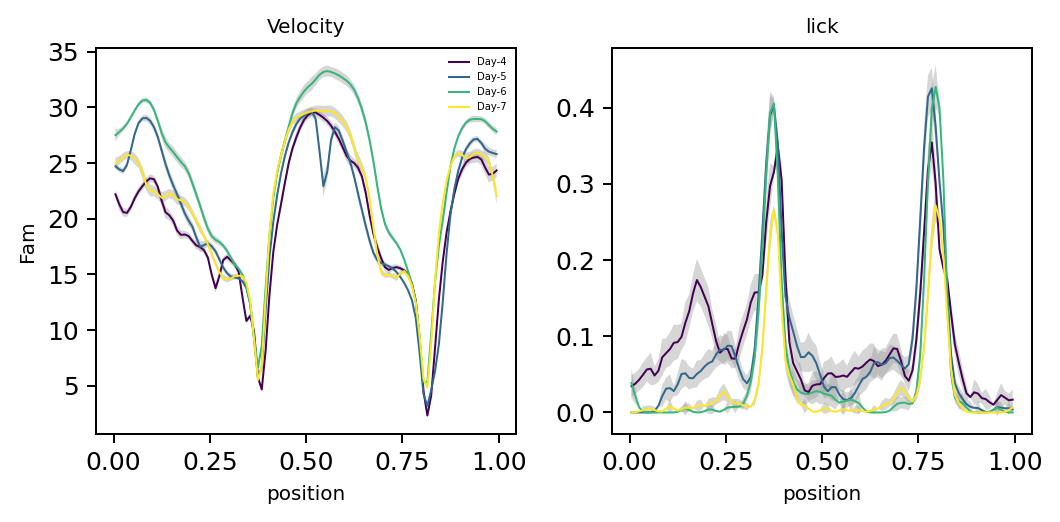

In [ ]:
# plt.plot(cTaskFramePos,cTaskFrameLicks,'ko',ms=1)
nContext = AllContextWiseBehav[0].shape[0]
fig32, ax02 = plt.subplots(nrows=nContext, ncols=2, figsize=(6, nContext+2),dpi=180)
nBins = 100
LocBins = np.linspace(0.0,1.0,nBins+1)

cmap = plt.get_cmap('viridis')
laplineColors = cmap(np.linspace(0,1,len(PairedSessDays)))
spbincents = (LocBins[:-1]+LocBins[1:])/2

PlotData = 0 # 0 indicates Velocity, 1 indicates licks, 2 indicates reward
PlotDataStr = ['Velocity','lick']
cContext = 0
ContextStrs = ['Fam','Nov1','Fam','Nov2']
UsedInds = np.arange(0,len(PairedSessDays)).astype('int')

cContext = 0
k = 0
for cData in range(2):
    cax = ax02[cData]
    for Inds,Days in enumerate(UsedInds):
        cSessData = AllContextWiseBehav[Inds][cContext][cData]
        SmoothedTrace = gaussian_filter1d(cSessData[0],1)
        cax.fill_between(spbincents,SmoothedTrace-cSessData[1],SmoothedTrace+cSessData[1],
                    alpha=0.4,ec='none',fc=[0.6,0.6,0.6])
        cax.plot(spbincents,SmoothedTrace,lw=0.8,color=laplineColors[Inds],label=f"Day-{PairedSessDays[Inds]}")
    if cData%2 == 0:
        cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
        cax.set_ylabel(f"{ContextStrs[cContext]}",fontsize=8)
        cax.set_xlabel("position",fontsize=8)
    else:
        cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
        cax.set_xlabel("position",fontsize=8)
    k += 1
ax02[0].legend(fontsize=4,loc='best',shadow=None,frameon=False)
plt.tight_layout()

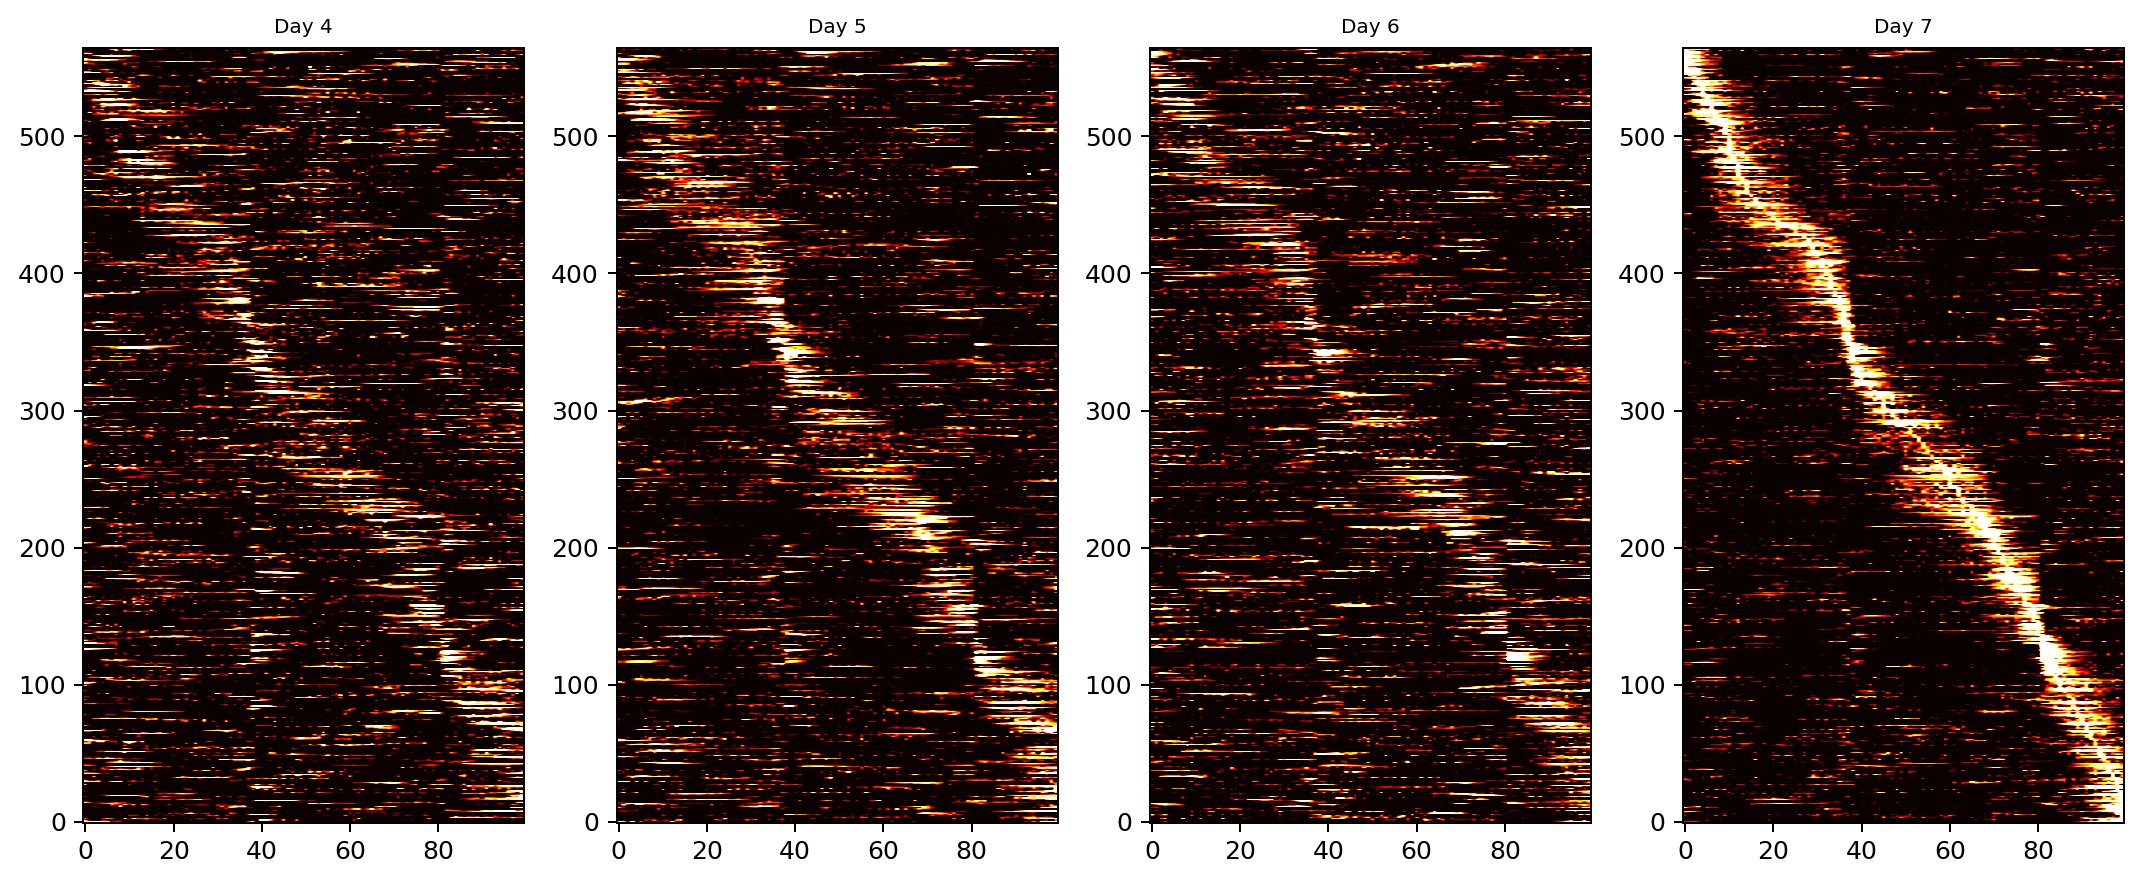

In [ ]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[:,UsedContext,:,3],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[:,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=2,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {PairedSessDays[cSess]}",fontsize=8)
plt.tight_layout()

# the behavior performance changes during imaging

# pick out the stable cells, fraction of it
# detection of place field, stability of PF criteria

# activity during ITI
# raw time serial data and labeled ITI data




In [ ]:
RefSess=0
UsedContext = 0
AllCorr2Ref = []
AllShufCorrs = []

for UsedSess in range(NumberofColumns-1):
    A = AllPairTVDatas[:,UsedContext,:,RefSess]
    B = AllPairTVDatas[:,UsedContext,:,UsedSess+1]
    diag_pear_coef = np.array([stats.pearsonr(A[i, :], B[i, :])[0] for i in range(A.shape[0])])
    if len(AllCorr2Ref) == 0:
        AllCorr2Ref = diag_pear_coef[:,np.newaxis]
    else:
        AllCorr2Ref = np.concatenate((AllCorr2Ref,diag_pear_coef[:,np.newaxis]),axis=1)
    
    A_shuf = copy.copy(A)
    random.shuffle(A_shuf)
    # random_samples2 = random.choice(B.shape[0], size=1000)
    B_shuf = copy.copy(B)
    random.shuffle(B_shuf)

    for c in range(5):
        ShufNullCorrs = [stats.pearsonr(A_shuf[i, :], B_shuf[i, :])[0] for i in range(A_shuf.shape[0])]
        AllShufCorrs.extend(ShufNullCorrs)
    
# ShufNullCorrs = 

In [ ]:
shufCorrthreshold = np.percentile(AllShufCorrs,[95,99])
Mtx = AllCorr2Ref>shufCorrthreshold[0]
SigROIs = np.argwhere(np.sum(Mtx,axis=1)>=3)[:,0]
SigROIs
# plt.imshow(AllCorr2Ref>shufCorrthreshold[0],aspect='auto',vmin=0,vmax=1)

array([  0,   3,   6,   8,  12,  23,  26,  37,  42,  44,  48,  69,  71,
        73,  76,  86,  93, 108, 111, 126, 136, 159, 167, 172, 180, 183,
       185, 190, 191, 192, 193, 198, 199, 204, 214, 221, 222, 230, 232,
       234, 236, 240, 248, 250, 253, 259, 260, 262, 273, 277, 301, 306,
       313, 319, 332, 341, 346, 348, 350, 351, 352, 353, 365, 369, 377,
       387, 394, 397, 399, 407, 408, 415, 417, 425, 429, 430, 434, 437,
       448, 449, 457, 458, 465, 477, 482, 493, 499, 504, 506, 507, 516,
       518, 522, 543, 544, 549, 551, 555, 564])

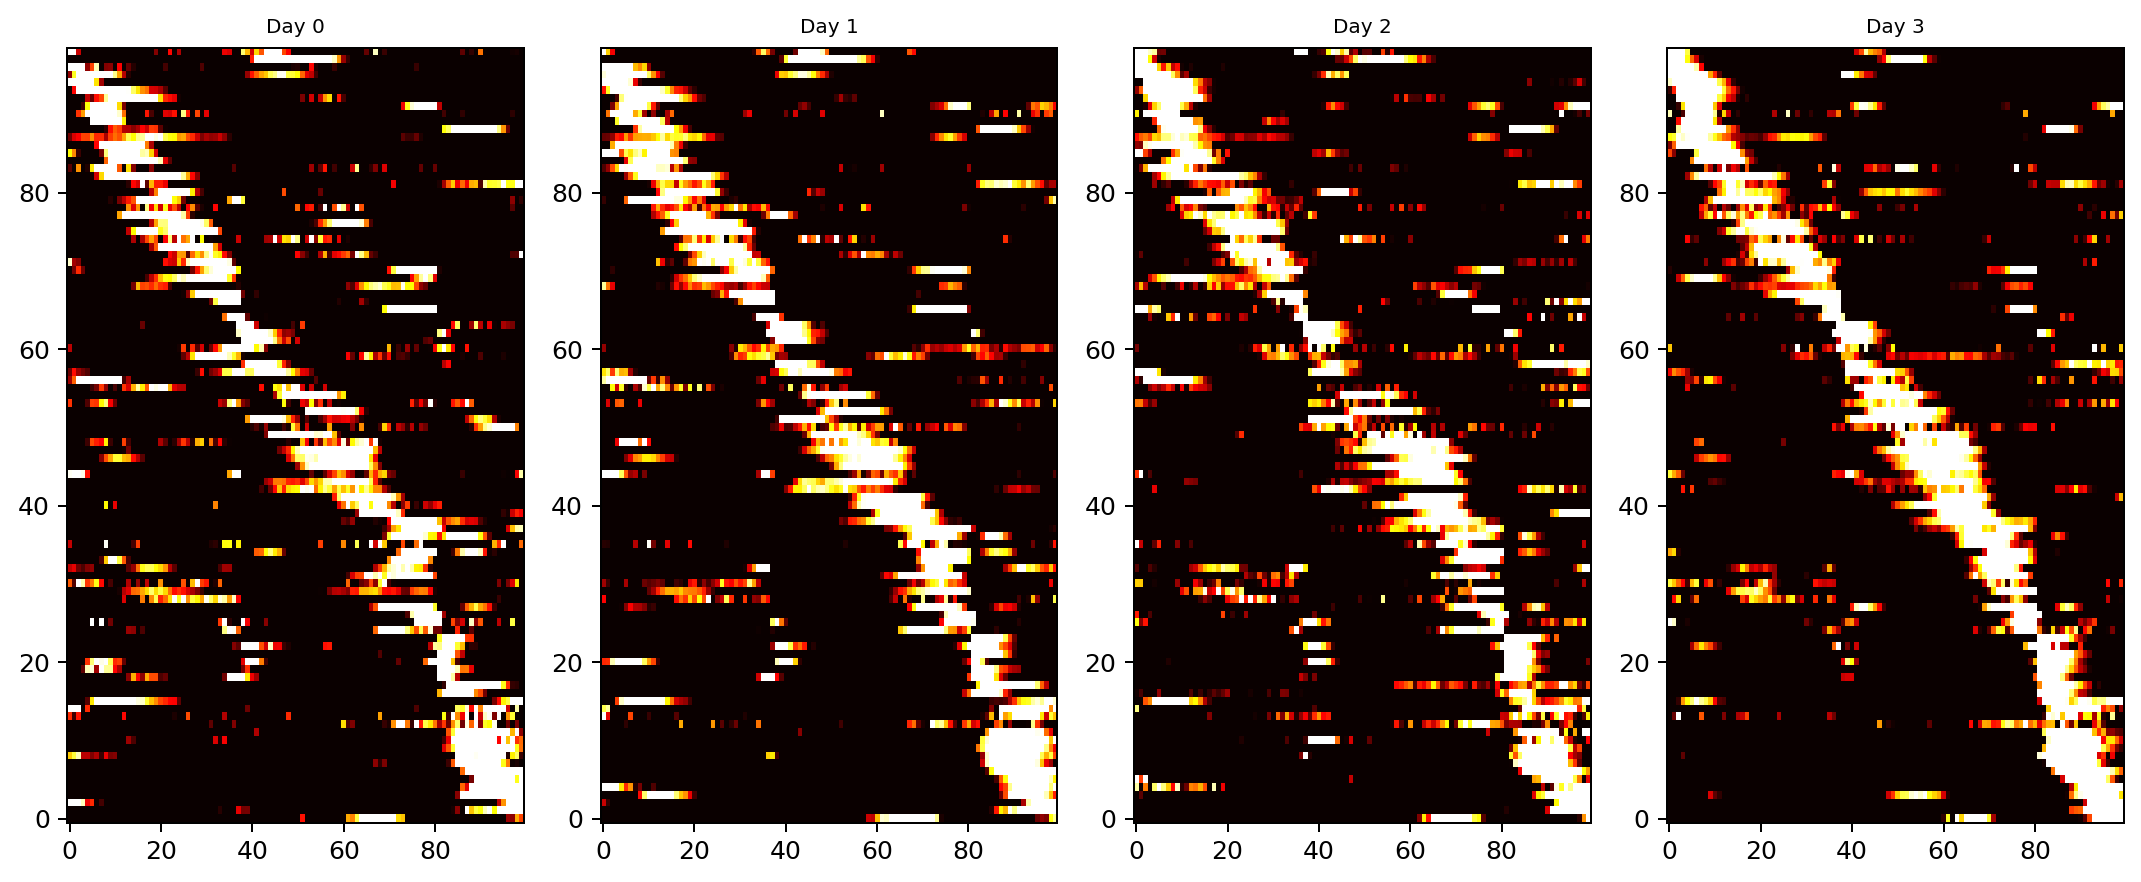

In [ ]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[SigROIs,UsedContext,:,3],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[SigROIs,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=1.6,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {UsedInds[cSess]}",fontsize=8)
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_traces(DataArr, IsPFcell, ax=None, linewidth=0.8, fill_color='r', Rowseqs=None,
                        fill_alpha=0.6, line_color='k', spacing_factor=1.2,IsSepplot = False):
    """
    Plot stacked traces from a 2D array with area fill for place field cells.
    
    Parameters:
    -----------
    DataArr : numpy.ndarray
        2D array where each row is a trace to be plotted
    IsPFcell : numpy.ndarray
        Boolean array indicating which rows are place field cells (True) to be filled
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure and axes will be created
    linewidth : float, optional
        Width of the trace lines
    fill_color : str, optional
        Color for filling area under place field cell traces
    fill_alpha : float, optional
        Alpha transparency for the fill (0-1)
    line_color : str, optional
        Color for the trace lines
    spacing_factor : float, optional
        Factor to control spacing between traces (higher = more space)
    IsSepplot: bool, optional
        whether seperately plot the PC and non-PC traces
    
    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axes with the plotted traces
    """
    # Check input dimensions
    if DataArr.shape[0] != len(IsPFcell):
        raise ValueError("DataArr and IsPFcell must have the same number of rows")
    if Rowseqs is None: 
        # sort data
        Rowpeaks = np.argmax(DataArr,axis=1)
        Rowseqs = np.argsort(Rowpeaks)
    else:
        # not performing seperate plots even if IsSepplot is True
        IsSepplot = False
        
    SortedDataArr = DataArr[Rowseqs,:]
    SortedIsPC = IsPFcell[Rowseqs]
    
    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 20),dpi=120)
    
    num_traces = DataArr.shape[0]
    x_vals = np.arange(DataArr.shape[1])
    
    # Calculate appropriate y-spacing
    trace_heights = np.array([np.max(DataArr[i]) - np.min(DataArr[i]) for i in range(num_traces)])
    max_height = np.max(trace_heights)
    y_spacing = max_height * spacing_factor
    if IsSepplot:
        Sorted_PCTraces = SortedDataArr[SortedIsPC]
        Sorted_NonPCTraces = SortedDataArr[~SortedIsPC]
        y_offset = 0
        # Plot each trace
        for i in range(Sorted_PCTraces.shape[0]):
            # Calculate y-offset for this trace
            
            # Fill area under curve if it's a place field cell
            # Plot the trace
            ax.plot(x_vals, Sorted_PCTraces[i] - y_offset, color='r', linewidth=linewidth)

            ax.fill_between(x_vals, -y_offset, Sorted_PCTraces[i] - y_offset, 
                           color=fill_color, alpha=fill_alpha)
            y_offset += y_spacing
        
        for ii in range(Sorted_NonPCTraces.shape[0]):
            ax.plot(x_vals, Sorted_NonPCTraces[ii] - y_offset, color=[.7,.7,.7], linewidth=linewidth*0.5)
            y_offset += y_spacing
            
            
    else:
        # Plot each trace
        for i in range(num_traces):
            # Calculate y-offset for this trace
            y_offset = i * y_spacing
            # Fill area under curve if it's a place field cell
            if SortedIsPC[i]:
                # Plot the trace
                ax.plot(x_vals, SortedDataArr[i] - y_offset, color='r', linewidth=linewidth)

                ax.fill_between(x_vals, -y_offset, SortedDataArr[i] - y_offset, 
                               color=fill_color, alpha=fill_alpha)
            else:
                ax.plot(x_vals, SortedDataArr[i] - y_offset, color=[.7,.7,.7], linewidth=linewidth*0.5)
    
    # Set y-ticks at the center of each trace
    # ax.set_yticks(np.arange(num_traces) * y_spacing)
    # ax.set_yticklabels([f'Cell {i+1}' for i in range(num_traces)])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([1,-y_offset-3])
    
    # # Set labels
    # ax.set_xlabel('Position')
    # ax.set_ylabel('Cell ID')
    
    return ax,Rowseqs

In [ ]:
AllPairTVDatas.shape
# AllPairTVDatas  AllpairIsPC

(565, 1, 100, 4)

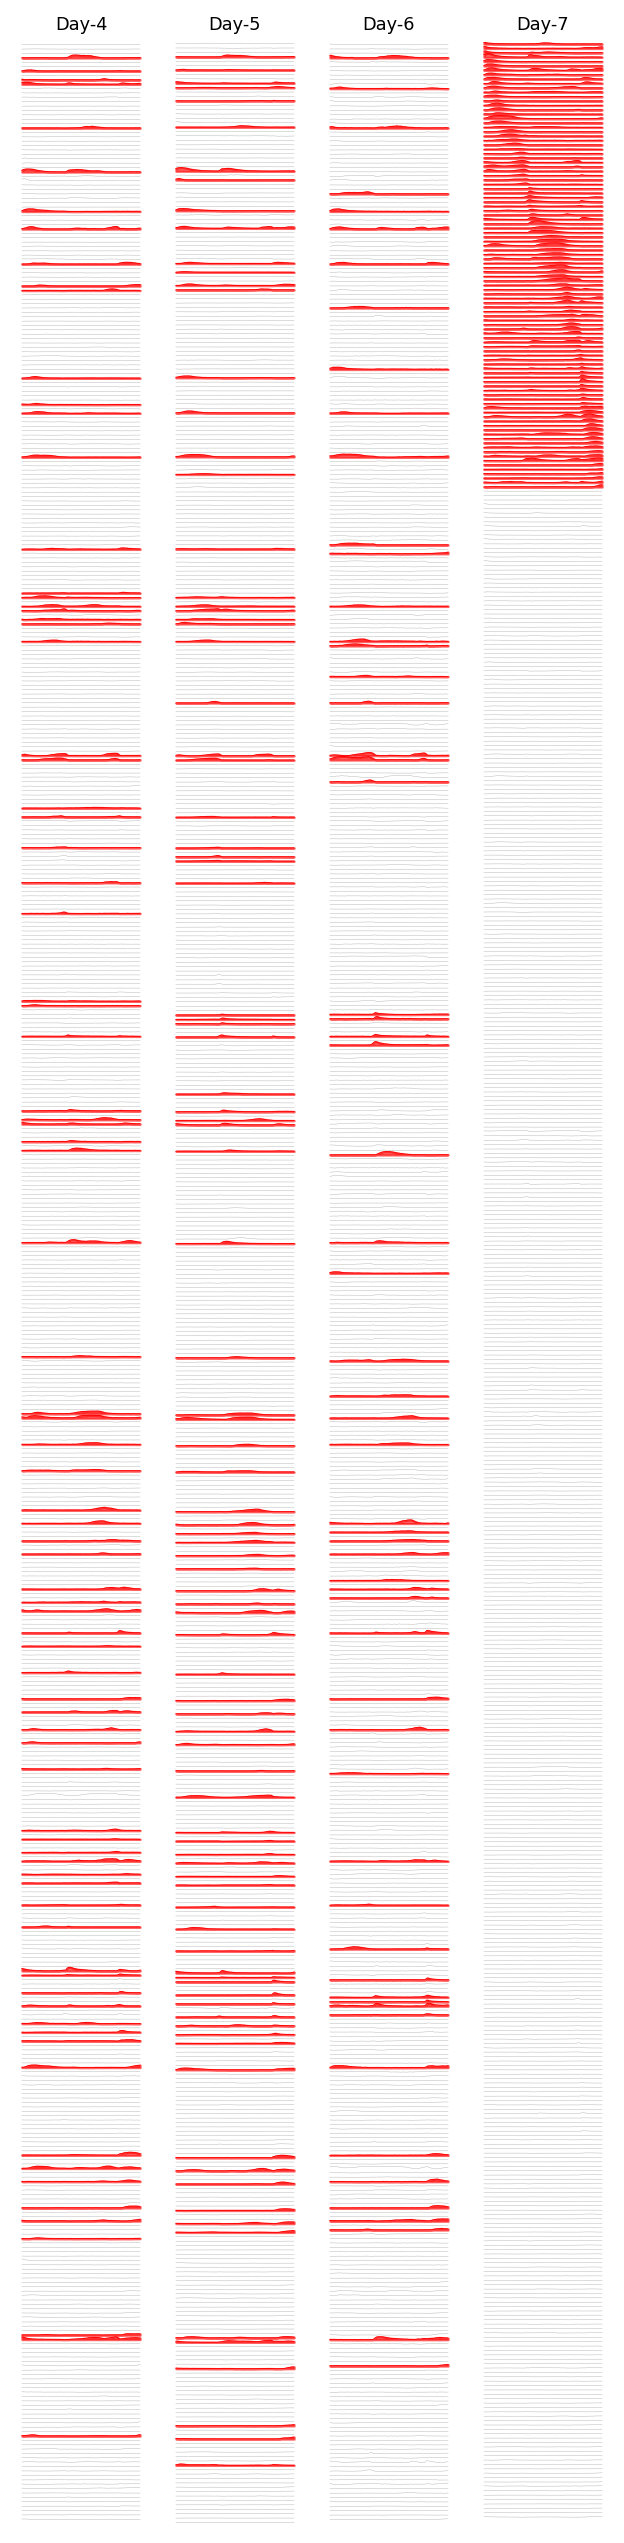

In [ ]:
cContext = 0

PlotSess = [0,1,2,3] #UsedDayStr
PlotDayStr = [UsedDayStr[c] for c in PlotSess]
numofSess = len(PlotSess)
SortSeq = None
fig, axAll = plt.subplots(nrows=1, ncols=numofSess,figsize=(1*numofSess, 16),dpi=160)
for inds,cSess in enumerate(PlotSess):
    ax = axAll[len(PlotSess)-inds-1]
    ContexturnCurve = AllPairTVDatas[:,cContext,:,len(UsedDayStr)-cSess-1]
    ContextRIsPC = AllpairIsPC[len(UsedDayStr)-cSess-1][cContext]
    # print(ContexturnCurve.shape)
    # print(ContextRIsPC.shape)
    ax,SortSeq = plot_stacked_traces(ContexturnCurve, ContextRIsPC,ax=ax,Rowseqs=SortSeq,linewidth=0.4,IsSepplot = True)
    
    ax.set_axis_off()
    ax.set_title(f"Day-{PlotDayStr[len(PlotSess)-inds-1]}",fontsize=8)
    ax.invert_yaxis()

plt.tight_layout()
